# Preparing ATSD-Signs for Training Traffic Sign Classifiers

---

This notebook is part of https://github.com/risc-mi/atsd.

This notebook demonstrates how the publicly available [ATSD-Signs](https://contentportal.asfinag.at/traffic-sign-catalogue) data set can effectively be analyzed and pre-processed for training traffic sign classifiers.

## Package Imports

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from skimage.io import imread, imsave
from skimage import color
import cv2
from tqdm import tqdm
import shutil
from matplotlib import pyplot as plt

## Paths

Set `ROOT` to the path to the directory where ATSD-Signs is located. This is the directory containing folders `"/train"` and `"/test"`.

In [2]:
ROOT = Path('path/to/atsd-signs')

## Data Inspection

Load tables with meta-information about training- and test images:

In [3]:
meta_train = pd.read_csv(ROOT / 'train/meta_train.csv', index_col=0)
meta_test = pd.read_csv(ROOT / 'test/meta_test.csv', index_col=0)

In [4]:
meta_train.head()

,id,type,not_normal_to_roadway,fog,tunnel,damaged,trimmed,covered,rain,overexposed,underexposed,shades
0,50,plate,False,False,False,False,False,False,False,False,False,False
1,51,led,False,False,False,False,False,False,False,False,False,False
2,52,plate,False,False,False,False,False,False,False,False,False,False
3,53,led,False,False,False,False,False,False,False,False,False,False
4,54,led,False,False,False,False,False,False,False,False,False,False


In [5]:
meta_test.head()

,id,type,not_normal_to_roadway,fog,tunnel,damaged,trimmed,covered,rain,overexposed,underexposed,shades
0,122,prismatic,False,False,False,False,False,False,False,False,False,False
1,123,led,False,False,False,False,False,False,False,False,False,False
2,124,led,False,False,False,False,False,False,False,False,False,False
3,125,plate,False,False,False,False,False,False,False,False,False,False
4,128,plate,False,False,False,False,False,False,False,False,False,False


As can be seen, both tables contain information about the ID of each image (i.e., its file name), the type (material) of the displayed traffic sign, and some boolean attributes. The class of the images is not included in the tables, since it is implicitly known from the image-IDs and the directories where the images are located. It is more convenient to explicitly add the class, though:

In [6]:
meta_train.set_index('id', inplace=True)
meta_train['class_id'] = ''
for cls in (ROOT / 'train').iterdir():
    if cls.is_dir():
        cls_id = cls.stem
        for f in cls.iterdir():
            meta_train.loc[int(f.stem), 'class_id'] = cls_id
meta_train.reset_index(inplace=True)

The same could be done for the test set as well, of course.

We can now plot one sample image for every class:

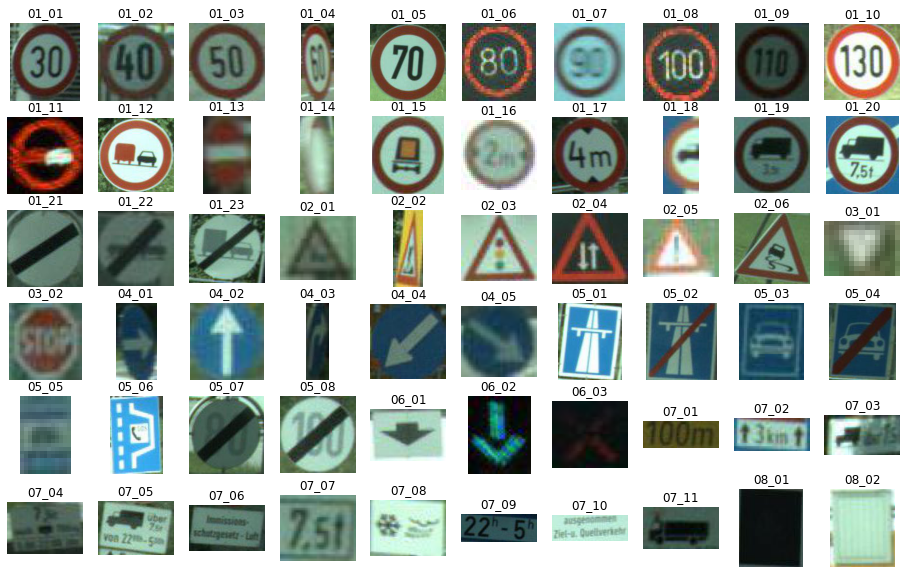

In [7]:
_, axes = plt.subplots(6, 10, figsize=(16, 10))
for i, cls_id in enumerate(sorted(meta_train['class_id'].unique())):
    img_id = np.random.choice(meta_train.loc[meta_train['class_id'] == cls_id, 'id'], 1)[0]
    img = imread(ROOT / 'train' / cls_id / (str(img_id) + '.jpg'))
    axes[i // 10, i % 10].imshow(img)
    axes[i // 10, i % 10].set_title(cls_id)
    axes[i // 10, i % 10].axis('off')

Let's print some summary statistics of the training set as follows:

In [8]:
meta_train['type'].value_counts()

plate        6559
led          4090
prismatic     319
backlit        88
Name: type, dtype: int64

In [9]:
meta_train[[c for c in meta_train.columns if c not in ('id', 'class_id', 'type')]].mean()

not_normal_to_roadway    0.081042
fog                      0.000090
tunnel                   0.069465
damaged                  0.006331
trimmed                  0.019175
covered                  0.015829
rain                     0.002623
overexposed              0.009588
underexposed             0.008954
shades                   0.005065
dtype: float64

The majority of traffic signs are ordinary metal plates, followed by a relatively large number of LED panels. Moreover, only very few images have one of the attributes set to `True`. Let's have a look at some random images where `"covered"` is set:

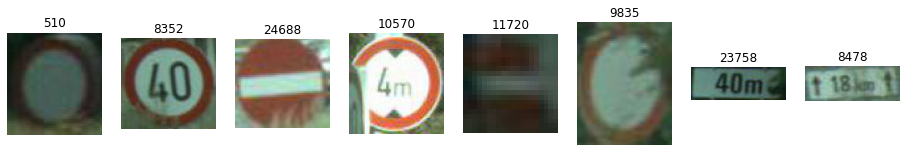

In [31]:
_, axes = plt.subplots(1, 8, figsize=(16, 4))
for i, idx in enumerate(np.random.choice(meta_train[meta_train['covered']].index, 8, replace=False)):
    img_id = meta_train.loc[idx, 'id']
    img = imread(ROOT / 'train' / meta_train.loc[idx, 'class_id'] / (str(img_id) + '.jpg'))
    axes[i].imshow(img)
    axes[i].set_title(img_id)
    axes[i].axis('off')

## Data Augmentation

Training data can be augmented by applying geometric transformations or converting images of non-LED traffic signs into "LED-like" images (and vice versa). This could be done during training, but here we show how it can be accomplished *before* the actual training starts.

The following dict describes how traffic sign images of the various classes can be rotated and/or flipped to obtain images of either the same or another traffic sign class. Class-IDs are mapped to dicts whose keys describe which geometric transformations are applicable:
* `"h"` (horizontal flip),
* `"v"` (vertical flip),
* `"90"` (counter-clockwise 90 degree rotation),
* `"180"` (180 degree rotation),
* `"270"` (counter-clockwise 270 degree rotation),
* `"t1"` (counter-clockwise 90 degree rotation followed by vertical flip),
* `"t2"` (counter-clockwise 90 degree rotation followed by horizontal flip).

Each of these descriptors is then mapped to the ID of the resulting class. For instance, images of class `"01_14"` ("no vehicles") can be flipped both horizontally and vertically, yielding again images of that same class. Actually, images of this class could be transformed in *all* ways listed above, but then the number of new images would become very large. Therefore, we opt to only flip the images. Analogous statements apply to `"08_01"` ("inactive LED panel") and `"08_02"` ("inactive prismatic inverter").

In [14]:
flip_rotate = {
    '01_01': {'v': '01_01'},                  # speed limit: 30km/h
    '01_13': {'h': '01_13', 'v': '01_13'},    # no entry
    '01_14': {'h': '01_14', 'v': '01_14'},    # no vehicles
    '01_15': {'h': '01_15'},                  # dangerous goods
    '01_21': {'180': '01_21'},                # end of speed limits and overtaking restrictions
    '02_03': {'h': '02_03'},                  # traffic lights
    '02_05': {'h': '02_05'},                  # danger
    '03_01': {'h': '03_01'},                  # yield
    '04_01': {'v': '04_01', '90': '04_02', 't2': '04_02'},   # direction to be followed (right)
    '04_02': {'h': '04_02', '270': '04_01', 't2': '04_01'},  # direction to be followed (left)
    '04_04': {'h': '04_05'},                  # pass this side (left)
    '04_05': {'h': '04_04'},                  # pass this side (right)
    '05_01': {'h': '05_01'},                  # motorway entrance
    '05_03': {'h': '05_03'},                  # road for motor vehicles
    '05_05': {'h': '05_05'},                  # tunnel
    '05_06': {'v': '05_06'},                  # emergency stopping place
    '06_01': {'h': '06_01'},                  # applies to this lane
    '06_02': {'h': '06_02'},                  # this lane is open
    '06_03': {'h': '06_03', 'v': '06_03', '90': '06_03', '180': '06_03', '270': '06_03', 't1': '06_03', 't2': '06_03'},   # this lane is closed
    '08_02': {'h': '08_02', 'v': '08_02'},    # inactive prismatic inverter
}

The following list contains all classes where LED transformation might make sense. This does *not* mean that LED- and non-LED versions actually exist for each of these classes (especially in the held-back internal set)!

In [15]:
led = ['01_01', '01_02', '01_03', '01_04', '01_05', '01_06', '01_07', '01_08', '01_09', '01_10', '01_11', '01_12', '01_15', '01_16',
       '01_17', '01_18', '01_19', '01_20', '01_21', '01_22', '01_23', '02_01', '02_02', '02_03', '02_04', '02_05', '02_06', '05_07',
       '05_08', '07_01', '07_02', '07_06']
len(led)

32

The following function converts images of non-LED traffic signs into the corresponding LED versions, and vice versa.

In [16]:
def change_colors(img: np.ndarray) -> np.ndarray:
    """
    Change colors in an image such that non-LED traffic signs appear LED-like, and vice versa.
    This boils down to inverting the L channel in Lab color space.
    
    @param img: The image to process, an array of shape `(h, w, 3)` and values in the [0, 1] interval.
    @return: The transformed image, an array with the same shape as `img` and values in the [0, 1] interval.
    """
    out = color.rgb2lab(img)
    out[:, :, 0] = out[:, :, 0].max() - out[:, :, 0]
    return color.lab2rgb(out)

Let's plot some sample images of class `"01_04"` ("speed limit: 60km/h"), where many LED and non-LED traffic signs are present in the training set. The top row shows the original images, the bottom row the transformed versions:

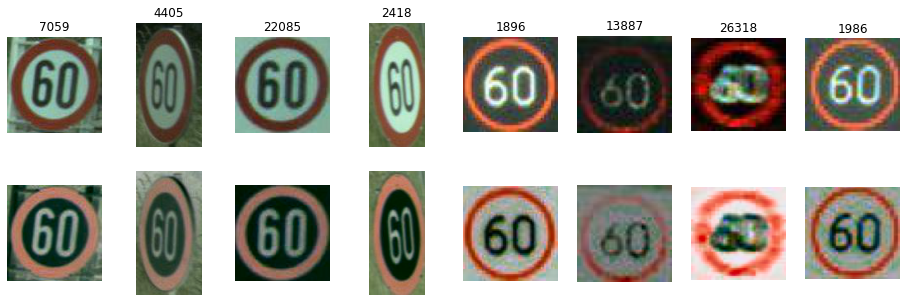

In [22]:
_, axes = plt.subplots(2, 8, figsize=(16, 5))
indexes = list(np.random.choice(meta_train[(meta_train['class_id'] == '01_04') & (meta_train['type'] == 'plate')].index, 4, replace=False)) + \
          list(np.random.choice(meta_train[(meta_train['class_id'] == '01_04') & (meta_train['type'] == 'led')].index, 4, replace=False))
for i, idx in enumerate(indexes):
    img_id = meta_train.loc[idx, 'id']
    img = imread(ROOT / 'train' / meta_train.loc[idx, 'class_id'] / (str(img_id) + '.jpg'))
    axes[0, i].imshow(img)
    axes[0, i].set_title(img_id)
    axes[0, i].axis('off')
    axes[1, i].imshow(change_colors(img / 255))
    axes[1, i].axis('off')

The function below augments the ATSD-Signs data set by applying geometric transformations (flip, rotate) and LED <-> non-LED conversions.

In [23]:
def augment(src: Path, dst: Path = None, flip_rotate=None, led=None):
    """
    Augment the data set by applying geometric transformations and LED <-> non-LED conversions.
    @param src: Source directory, typically `ROOT / "train"`.
    @param dst: Destination directory. None defaults to `src`.
    @param flip_rotate: Dict describing which images to transform geometrically, and how.
    @param led: List of class-IDs whose images shall be LED transformed.
    """
    
    if dst is None:
        dst = src
    if flip_rotate is None:
        flip_rotate = {}
    if led is None:
        led = ()
    
    files = []
    for c in src.iterdir():
        if c.is_dir():
            d = dst / c.stem
            d.mkdir(exist_ok=True, parents=True)
            files += [f for f in c.iterdir()]

    for f in tqdm(files):
        c = f.parent
        d = dst / c.stem
        fr = flip_rotate.get(c.stem, {})
        is_led = c.stem in led
        shutil.copyfile(f.as_posix(), (d / f.name).as_posix())
        if is_led:
            img = imread(f)
            led_img = np.round(change_colors(img / 255) * 255).astype(np.uint8)
            imsave((d / (f.stem + '_led.jpg')).as_posix(), led_img)
        else:
            img = None
            led_img = None
        if fr:
            if img is None:
                img = imread(f)
            if led_img is None:
                imgs = [(img, '_')]
            else:
                imgs = [(img, '_'), (led_img, '_led_')]
            for m, c0 in fr.items():
                d0 = dst / c0
                for aux, suffix in imgs:
                    if m == 'h':
                        aux = aux[:, ::-1]
                    elif m == 'v':
                        aux = aux[::-1]
                    elif m == '90':
                        aux = aux.transpose((1, 0, 2))[::-1]
                    elif m == '180':
                        aux = aux[::-1, ::-1]
                    elif m == '270':
                        aux = aux[::-1].transpose((1, 0, 2))
                    elif m == 't1':
                        aux = aux.transpose((1, 0, 2))
                    elif m == 't2':
                        aux = aux.transpose((1, 0, 2))[::-1, ::-1]
                    else:
                        continue
                    imsave((d0 / (f.stem + suffix + m + '.jpg')).as_posix(), aux)

Executing the cell below creates a new directory, `"train_flip_rotate_led"`, and populates it with the original training images, as well as flipped/rotated versions thereof according to dict `flip_rotate` and LED/non-LED versions according to list `led`. The new images bear the same name as the original ones, plus (optionally) suffix `"_led"`, plus (optionally) one of the suffixes `"_h"`, `"_v"`, etc.

In [ ]:
augment(ROOT / 'train', ROOT / 'train_flip_rotate_led', flip_rotate=flip_rotate, led=led)

Augmenting the test set is also possible, of course.

## Extracting Traffic Sign Patches from ATSD-Scenes

Every image in ATSD-Signs was extracted from a full traffic scene image, based on a tightly annotated bounding box. In real-world applications, traffic sign detectors will likely return bounding boxes that are less accurate, to some extent. Hence, in order to make the classifier robust against imperfectly detected traffic signs one can extract larger patches, with more context information, from the scene images of ATSD-Scenes. These larger patches can be randomly cropped during training.

The following function extracts the traffic sign images contained in ATSD-Signs from ATSD-Scenes, but allows to increase the size of the bounding box to include more scene context.

In [24]:
def extract_patches(meta_scenes: pd.DataFrame, meta_signs: pd.DataFrame, src: Path, dst: Path, w_factor=1.5, h_factor=1.5):
    """
    Extract traffic sign patches from ATSD-Scenes and save them in a directory.
    @param meta_scenes: DataFrame with meta-information about the annotated signs in ATSD-Scenes.
    @param meta_signs: DataFrame with meta-information about the images in ATSD-Signs.
    @param src: Directory containing the full traffic scene images from ATSD-Scenes.
    @param dst: Directory where the extracted patches shall be saved.
    @param w_factor: The factor by which to increase the width of the bounding box before extracting signs.
                     Larger values mean that more scene context is included.
    @param h_factor: The factor by which to increase the height of the bounding box before extracting signs.
                     Larger values mean that more scene context is included.
    """
    
    assert 'image_id' in meta_scenes.columns
    assert 'annotation_id' in meta_scenes.columns
    assert 'class_id' in meta_scenes.columns
    assert 'xtl' in meta_scenes.columns
    assert 'xbr' in meta_scenes.columns
    assert 'ytl' in meta_scenes.columns
    assert 'ybr' in meta_scenes.columns
    assert 'id' in meta_signs.columns
    
    df = meta_scenes[meta_scenes['annotation_id'].isin(meta_signs['id'].values)]
    
    for c in df['class_id'].unique():
        (dst / c).mkdir(parents=True, exist_ok=True)
        
    for img_id, grp in tqdm(df.groupby('image_id')):
        img = imread(src / (str(img_id) + '.jpg'))
        for i in grp.index:
            x = grp.loc[i, 'xtl']
            y = grp.loc[i, 'ytl']
            w = grp.loc[i, 'xbr'] - x
            h = grp.loc[i, 'ybr'] - y
            w0 = w * w_factor
            h0 = h * h_factor
            x0 = x - (w0 - w) * 0.5
            y0 = y - (h0 - h) * 0.5
            x1 = int(round(x0 + w0))
            y1 = int(round(y0 + h0))
            x0 = int(round(max(0, x0)))
            y0 = int(round(max(0, y0)))
            w0 = x1 - x0
            h0 = y1 - y0
            imsave(dst / grp.loc[i, 'class_id'] / (str(grp.loc[i, 'annotation_id']) + '.jpg'), img[y0:y0 + h0, x0:x0 + w0])

For being able to extract patches from ATSD-Scenes, `SCENE_ROOT` must be set to the directory containing ATSD-Scenes (i.e., the directory containing folders `"/train"` and `"/test"`):

In [25]:
SCENE_ROOT = Path('path/to/atsd-scenes')

Extract patches from the training set, after increasing both width and height of the bounding boxes by a factor of $1.5$. Save the resulting images in the `"/train"` folder of a new directory called `"ATSD_context"`. The same can be done for the test set as well.

In [ ]:
extract_patches(
    pd.read_csv(SCENE_ROOT / 'train/meta_train.csv'),
    meta_train,
    SCENE_ROOT / 'train/imgs',
    ROOT.parent / 'ATSD_context/train',
    w_factor=1.5,
    h_factor=1.5
)

**NOTICE**<br>
After executing the above cell the newly created training set will contain slightly fewer images than the original training set of ATSD-Signs (10952 instead of 11056). This owes to the fact that some traffic sign images in ATSD-Signs were extracted from scene images that are not contained in ATSD-Scenes. Anyway, the difference is only minor.